# Euler Bernoulli Beam Equation: ODE-ELM, ODE-SWIM solution

In [26]:
import sys
sys.path.append('../../')
sys.path.append('../../src')
from swimpde import Domain
from swimpde import BoundaryCompliantAnsatz
from swimpde import EulerBernoulliSolver
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

#testing
import time
import matplotlib.cm as cm
cmap = cm.jet
import matplotlib.ticker as ticker

### 1. Define the domain

In [27]:
# Number of test points in space
n_test = 256
t_eval = np.linspace(0, 1, 100)
# Set time domain
n_t = 100

# Domain: 1-d space with uniform grid
x_lim = [0, np.pi]

# initial condition
def u0(x):
    return np.sin(x)

def ut0(x):
    return np.zeros_like(x)

# boundary condition
boundary_condition = "periodic" #"zero dirichlet second order"  #"periodic strict" #strict

# forcing
def forcing(x, t):
    return (1. - 16* np.pi**2 ) * np.sin(x) * np.cos(4 * np.pi * t)

# Analytical solution
def analytical_sol(x, t):
    return np.sin(x) * np.cos(4 * np.pi * t)

# Periodic basis functions
def periodic_outer_basis_sine(x_space, n_outer_basis=None, initial_condition=None):
    return np.column_stack([
        sine(x_space * (i+1))
        for i in range(n_outer_basis)
        for sine in [np.sin]
    ])



### Fit the SWIM network

In [28]:
experiments = []
# List of all hyper-parameters
n_x = 400
reg_pinv_ic =1e-12
reg_pinv_ic = 1e-12 
reg_OBF = 1e-12
# Data points / number of basis functions
seeds = [1, 2, 3]
n_IBF = 200
n_OBF = 10
experiments = []

x_space = np.linspace(x_lim[0], x_lim[1], n_x).reshape((-1, 1))

# interior points
x_space_inner = x_space[1:-1]
interior_points = x_space_inner

# coordinates of boundary points (excluding corners)
left = x_lim[0]
right = x_lim[1]
boundary_points = np.row_stack([left, right])

domain = Domain(
    interior_points=interior_points,
    boundary_points=boundary_points,
)

# Parameter sampler for ELM: Sample weights from a normal distribution and biases uniformly from [-4, 4]
def sample_parameters_randomly(x, _, rng):
    weights = rng.normal(loc=0, scale=1, size=(x.shape[1], n_IBF))
    biases = rng.uniform(low=-2, high=2, size=(1, n_IBF)) # low=-np.pi, high=np.pi,  2 * np.pi
    idx0 = None
    idx1 = None
    return weights, biases, idx0, idx1

# Set boundary conditions
boundary_condition = "periodic"

# Loop over different seeds
rmse_swim = np.ones((len(seeds), ))
rmse_elm = np.ones((len(seeds), ))
rel_err_swim = np.ones((len(seeds), ))
rel_err_elm = np.ones((len(seeds), ))
time_swim = np.ones((len(seeds), ))
time_elm = np.ones((len(seeds), ))
j = 0
info = []
for seed in seeds:
    # Set inner basis functions
    ansatz_elm = BoundaryCompliantAnsatz(
        n_outer_basis=n_OBF,
        n_inner_basis=n_IBF,
        activation="tanh",
        target_gen=periodic_outer_basis_sine,
        random_state=seed,
        regularization_scale=reg_OBF,
        parameter_sampler=sample_parameters_randomly,
        domain_margin_percent=0.1,
        scale_bc = 100.,

    )
    ansatz_swim = BoundaryCompliantAnsatz(
        n_outer_basis=n_OBF,
        n_inner_basis=n_IBF,
        activation="tanh",
        target_gen=periodic_outer_basis_sine,
        random_state=seed,
        regularization_scale=reg_OBF,
    )

    # Set advection solver
    euler_bernoulli_solver_swim = EulerBernoulliSolver(
        domain=domain, 
        ansatz=ansatz_swim,
        u0=u0,
        ut0=ut0,
        boundary_condition=boundary_condition,
        forcing=forcing,
        regularization_scale=reg_pinv_ic
    )
    euler_bernoulli_solver_elm = EulerBernoulliSolver(
        domain=domain, 
        ansatz=ansatz_elm,
        u0=u0,
        ut0=ut0,
        boundary_condition=boundary_condition,
        forcing=forcing,
        regularization_scale=reg_pinv_ic
    )
    
    # Compute weights and biases of the SWIM network
    time_blocks = 1
    t_swim_start = time.time()
    sol= euler_bernoulli_solver_swim.fit(t_span=[0, np.max(t_eval)], rtol = 1e-10, atol = 1e-10); #, num_svd=50
    t_swim_stop = time.time()
    time_swim[j] = t_swim_stop - t_swim_start
    
    t_elm_start = time.time()
    euler_bernoulli_solver_elm.fit(t_span=[0, np.max(t_eval)], rtol = 1e-10, atol = 1e-10);#, num_svd=50
    t_elm_stop = time.time()
    time_elm[j] = t_elm_stop - t_elm_start
    

    # Evaluate solution
    x_space_test = np.linspace(np.min(x_space), np.max(x_space), n_test).reshape((-1, 1))
    u_true_test = analytical_sol(x_space_test, t_eval).T
    u_elm_test = euler_bernoulli_solver_elm.evaluate(x_eval=x_space_test, t_eval = t_eval).T
    u_swim_test = euler_bernoulli_solver_swim.evaluate(x_eval=x_space_test, t_eval = t_eval).T
    
    # Store useful info for plotting
    mse_elm = mean_squared_error(u_true_test, u_elm_test)  # mean squared error
    rmse_elm[j] = np.sqrt(mse_elm)  # Root Mean Squared Error
    mse_swim = mean_squared_error(u_true_test, u_swim_test)  # mean squared error
    rmse_swim[j] = np.sqrt(mse_swim)  # Root Mean Squared Error
    rel_err_elm[j] = rmse_elm[j]/np.sqrt(mean_squared_error(u_true_test, np.zeros_like(u_true_test)))
    rel_err_swim[j] = rmse_swim[j]/np.sqrt(mean_squared_error(u_true_test, np.zeros_like(u_true_test)))
    j = j + 1
    
info.append(np.mean(time_elm))
info.append(np.mean(time_swim))
info.append(np.mean(rmse_elm))
info.append(np.std(rmse_elm))
info.append(np.mean(rmse_swim))
info.append(np.std(rmse_swim))
info.append(np.mean(rel_err_elm))
info.append(np.std(rel_err_elm))
info.append(np.mean(rel_err_swim))
info.append(np.std(rel_err_swim))
print('elm time = ', np.mean(time_elm), 'swim time', np.mean(time_swim))
print('rmse elm = ',np.mean(rmse_elm), '+-', np.std(rmse_elm))
print('rmse swim = ',np.mean(rmse_swim), '+-', np.std(rmse_swim))
print('rel l-2 error elm',np.mean(rel_err_elm), '+-', np.std(rel_err_elm))
print('rel l-2 error swim',np.mean(rel_err_swim), '+-', np.std(rel_err_swim))
experiments.append(info)



Integration successful.
Integration successful.
Integration successful.
Integration successful.
Integration successful.
Integration successful.
elm time =  0.08053151766459148 swim time 0.0851132074991862
rmse elm =  1.7576782931737323e-08 +- 3.910091870412992e-09
rmse swim =  6.062669147553227e-08 +- 2.966283572970679e-08
rel l-2 error elm 3.504762477371116e-08 +- 7.79661632263372e-09
rel l-2 error swim 1.2088796581024773e-07 +- 5.9146883728183974e-08


### Solution comparison

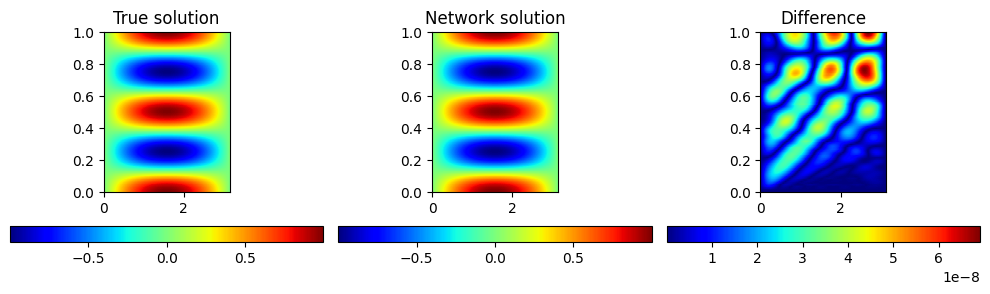

In [29]:
# visualize the solution
fig, ax = plt.subplots(1, 3, figsize=(10, 3))
plt.rcParams['image.cmap'] = 'jet' #'brg'

extent = [np.min(x_space), np.max(x_space), 0 , 1]
aspect = 4
sol_img1 = ax[0].imshow(u_true_test, extent=extent, origin='lower', aspect=aspect)#, vmin=vlim[0], vmax=vlim[1]
sol_img2 = ax[1].imshow(u_swim_test, extent=extent, origin='lower', aspect=aspect)#, vmin=vlim[0], vmax=vlim[1]
error_img = ax[2].imshow(abs(u_swim_test - u_true_test),  extent=extent, origin='lower', aspect=aspect)

fig.colorbar(sol_img1, ax=ax[0], location='bottom')
fig.colorbar(sol_img2, ax=ax[1], location='bottom')
fig.colorbar(error_img, ax=ax[2], location='bottom')

ax[0].set_title('True solution')
ax[1].set_title('Network solution')
ax[2].set_title('Difference')

fig.tight_layout()

# Error plots

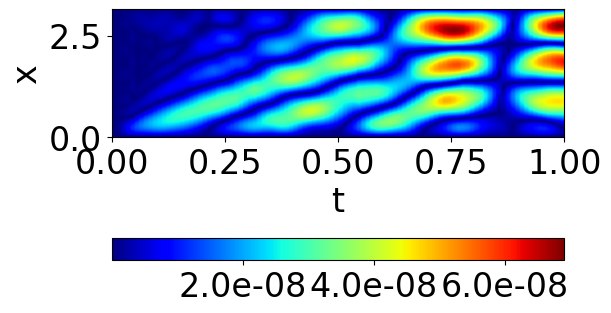

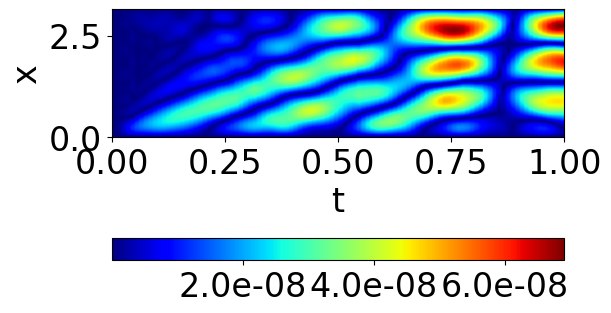

In [49]:
fontsize = 24
aspect = 0.09

# visualize the solution
fig, ax = plt.subplots(1, 1, figsize=(6, 5), constrained_layout=True)#
extent = [np.min(t_eval) , np.max(t_eval), np.min(x_space), np.max(x_space)]
sol_img1 = ax.imshow(abs(u_swim_test-u_true_test).T, extent=extent, origin='lower', aspect=aspect, cmap=cmap)#, vmin=vlim[0], vmax=vlim[1]
cb = fig.colorbar(sol_img1, ax=ax, location='bottom',aspect=20)#, fraction=0.046 * 3 

# Set the formatter for the colorbar to scientific notation
cb.formatter = ticker.FuncFormatter(lambda x, pos: f'{x:.1e}')
cb.update_ticks()

# Set the font size of the colorbar labels
cb.ax.tick_params(labelsize=fontsize)  # Change 12 to your desired font size
ax.set_xlabel('t', fontsize=fontsize)
ax.set_ylabel('x', fontsize=fontsize)
plt.tick_params(axis='both', labelsize=fontsize)
plt.savefig('bernoulli_error_swim.pdf')

# visualize the solution
fig, ax = plt.subplots(1, 1, figsize=(6, 5), constrained_layout=True)#
extent = [np.min(t_eval) , np.max(t_eval), np.min(x_space), np.max(x_space)]
sol_img1 = ax.imshow(abs(u_swim_test-u_true_test).T, extent=extent, origin='lower', aspect=aspect, cmap=cmap)#, vmin=vlim[0], vmax=vlim[1]
cb = fig.colorbar(sol_img1, ax=ax, location='bottom',aspect=20)#, fraction=0.046 * 3 

# Create the colorbar

# Set the formatter for the colorbar to scientific notation
cb.formatter = ticker.FuncFormatter(lambda x, pos: f'{x:.1e}')
cb.update_ticks()

# Set the font size of the colorbar labels
cb.ax.tick_params(labelsize=fontsize)  # Change 12 to your desired font size

#ax.set_title('True solution', fontsize=fontsize)
#cb.ax.tick_params(labelsize=fontsize)
ax.set_xlabel('t', fontsize=fontsize)
ax.set_ylabel('x', fontsize=fontsize)
plt.tick_params(axis='both', labelsize=fontsize)
plt.savefig('bernoulli_error_elm.pdf')
